In [ ]:
!pip install opencv-python-headless


Saving 8at6Y.png to 8at6Y.png
1 image(s) uploaded.

Processing Image: 8at6Y.png
Attempting specialized checkerboard pattern detection...
Method 0 (Specialized Pattern Detection):
  White Squares: 63
  Black Squares: 74
  Total Squares: 137
  Average Square Size: 34x32px
  Found sufficient squares, skipping other methods


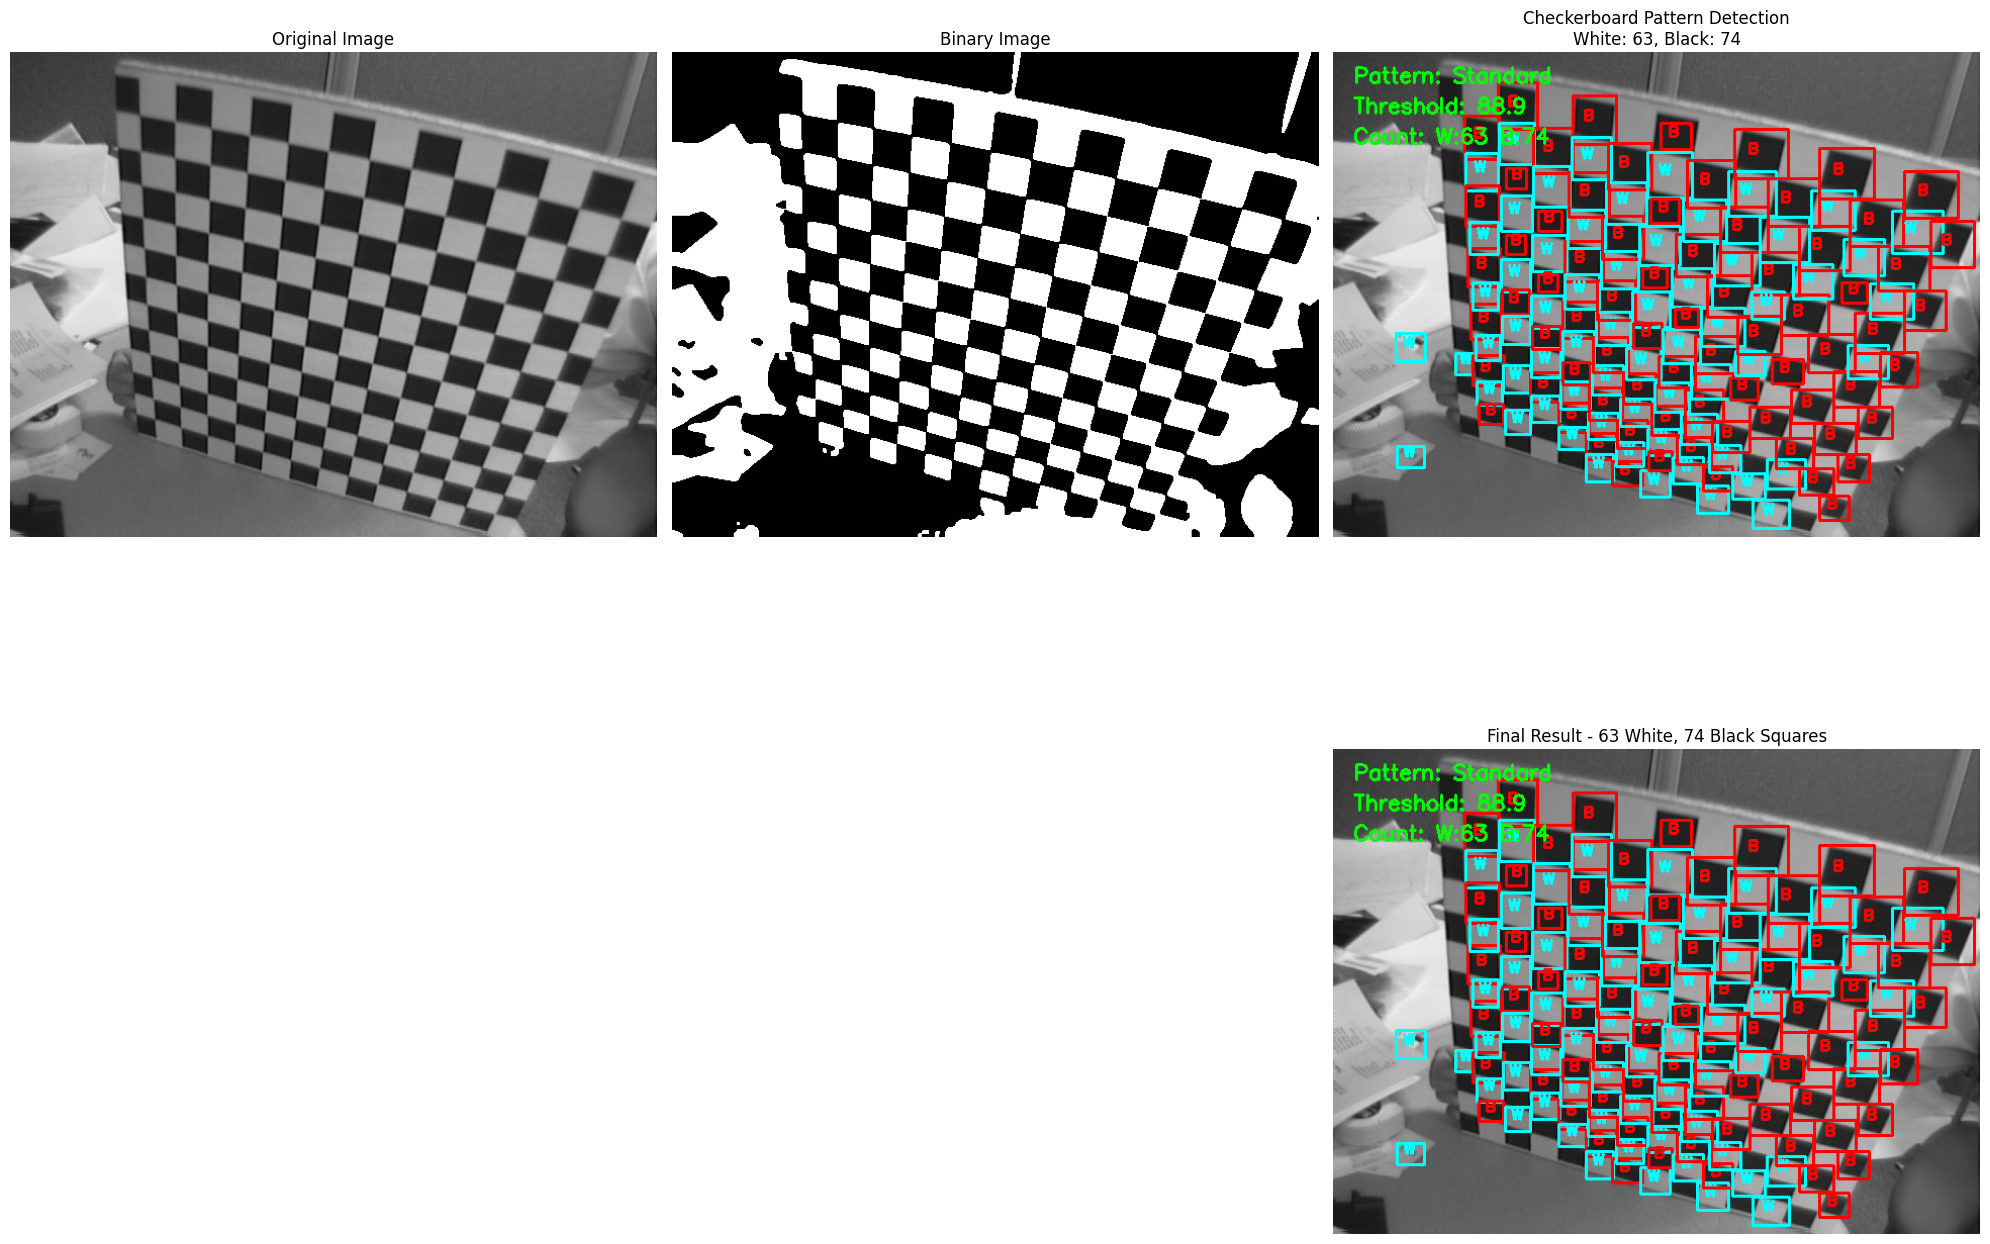

In [3]:
# Step 1: Install & Import Required Libraries
# Install required packages
import sys
import subprocess
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'opencv-python-headless'])

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files
from PIL import Image
import io
from sklearn.cluster import DBSCAN

# Step 2: Upload Chessboard Images
# Upload the chessboard images you want to process
uploaded = files.upload()

# Load uploaded images into a list
image_list = []
for filename in uploaded.keys():
    img = Image.open(io.BytesIO(uploaded[filename]))
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image_list.append((img, filename))

print(f"{len(image_list)} image(s) uploaded.")

# Step 3: Improved Preprocessing with better noise handling
def preprocess_image(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Estimate if the image has uneven lighting or shadows
    h, w = gray.shape
    # Split the image into quadrants and calculate mean brightness
    q1 = np.mean(gray[:h//2, :w//2])
    q2 = np.mean(gray[:h//2, w//2:])
    q3 = np.mean(gray[h//2:, :w//2])
    q4 = np.mean(gray[h//2:, w//2:])

    # Calculate variance between quadrants to detect uneven lighting
    quad_values = [q1, q2, q3, q4]
    lighting_variance = np.std(quad_values)
    has_uneven_lighting = lighting_variance > 15

    # Adaptive approach based on image conditions
    if has_uneven_lighting:
        print(f"Detected uneven lighting (variance: {lighting_variance:.2f}), applying additional corrections")
        # Apply CLAHE first for more aggressive contrast normalization
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        equalized = clahe.apply(gray)

        # Apply bilateral filter to preserve edges while reducing noise
        bilateral = cv2.bilateralFilter(equalized, 9, 75, 75)

        # Add mild Gaussian blur to further reduce noise
        blur = cv2.GaussianBlur(bilateral, (5, 5), 0)
    else:
        # Standard preprocessing for even lighting
        # Apply Gaussian Blur to reduce noise
        blur = cv2.GaussianBlur(gray, (5, 5), 0)

        # Enhance contrast using CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        equalized = clahe.apply(blur)

        # Mild bilateral filter
        bilateral = cv2.bilateralFilter(equalized, 7, 50, 50)

        # Use bilateral as our base
        blur = bilateral

    # Try multiple thresholding approaches for different lighting conditions
    binary_versions = []

    # 1. Standard adaptive thresholding (good for even lighting)
    binary1 = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )
    binary_versions.append(binary1)

    # 2. More aggressive thresholding (good for low contrast)
    binary2 = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 19, 4
    )
    binary_versions.append(binary2)

    # 3. Otsu thresholding (good for high contrast images)
    _, binary3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    binary_versions.append(binary3)

    # 4. CLAHE enhanced thresholding (good for uneven lighting)
    clahe_enhanced = clahe.apply(blur)
    binary4 = cv2.adaptiveThreshold(
        clahe_enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )
    binary_versions.append(binary4)

    # 5. Inverted thresholding (useful for dark backgrounds)
    binary5 = cv2.bitwise_not(binary1)
    binary_versions.append(binary5)

    # 6. Edge enhanced version (useful for partial views with strong edges)
    edges = cv2.Canny(blur, 30, 150)
    dilated_edges = cv2.dilate(edges, None, iterations=1)
    edge_enhanced = cv2.bitwise_and(binary1, cv2.bitwise_not(dilated_edges))
    binary_versions.append(edge_enhanced)

    # Apply morphological operations to clean up each binary image
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_medium = np.ones((5, 5), np.uint8)

    cleaned_versions = []
    for binary in binary_versions:
        # Start with opening to remove small noise
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_small)
        # Follow with closing to fill small holes
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel_small)
        cleaned_versions.append(cleaned)

    # Special handling for images with high noise or challenging lighting
    # Add a more aggressively cleaned version
    if has_uneven_lighting:
        for binary in [binary1, binary3, binary4]:
            aggressive_clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_medium)
            aggressive_clean = cv2.morphologyEx(aggressive_clean, cv2.MORPH_CLOSE, kernel_medium)
            cleaned_versions.append(aggressive_clean)

    # Find the binary version with the best contrast between squares
    # Calculate standard deviation as a measure of "chessboard-ness"
    best_stddev = 0
    best_binary = cleaned_versions[0]

    for binary in cleaned_versions:
        # Calculate standard deviation of pixel values
        stddev = np.std(binary)
        if stddev > best_stddev:
            best_stddev = stddev
            best_binary = binary

    # Return the grayscale, best binary, and all cleaned binary versions
    return gray, best_binary, cleaned_versions

# Step 4: Detect Chessboard and Correct Perspective
def detect_chessboard(img, binary, alt_binaries=None):
    # If alt_binaries is not provided, use only the main binary image
    if alt_binaries is None:
        alt_binaries = [binary]

    # Try with each binary image until we find a valid chessboard
    for binary_img in [binary] + alt_binaries:
        # Apply additional noise reduction for better contour detection
        cleaned_binary = cv2.medianBlur(binary_img, 5)

        # Find contours in the binary image
        contours, _ = cv2.findContours(cleaned_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            continue

        # Sort contours by area (largest first)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)

        chessboard_contour = None
        # Check more contours for challenging angles (increased from 25 to 30)
        for contour in contours[:30]:
            # Approximate the contour
            perimeter = cv2.arcLength(contour, True)

            # More adaptive epsilon for complex polygon approximation
            # For smaller contours, use a higher epsilon to capture simpler shapes
            area = cv2.contourArea(contour)
            if area < 5000:
                epsilon = 0.05 * perimeter
            elif area < 20000:
                epsilon = 0.03 * perimeter
            else:
                epsilon = 0.02 * perimeter

            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Accept quadrilaterals with 4 points, but also handle more complex shapes (4-8 points)
            if 4 <= len(approx) <= 8:
                # If more than 4 points, simplify to 4
                if len(approx) > 4:
                    # Find the minimum area rectangle
                    rect = cv2.minAreaRect(approx)
                    box = cv2.boxPoints(rect)
                    # Fix: Use np.int32 instead of np.int0
                    approx = np.int32(box)

                # Lower the area threshold to catch smaller or partially visible chessboards
                # Now only requiring 1% of image area instead of 2%
                if cv2.contourArea(approx) > img.shape[0] * img.shape[1] * 0.01:
                    # Relaxed aspect ratio check for severely angled boards
                    (x, y, w, h) = cv2.boundingRect(approx)
                    aspectRatio = float(w) / h
                    # Expanded range for aspect ratio to handle extreme angles
                    if 0.4 <= aspectRatio <= 2.5:
                        chessboard_contour = approx
                        break

        if chessboard_contour is None:
            continue  # Try the next binary image

        # Draw the detected chessboard contour
        detected_image = img.copy()
        cv2.drawContours(detected_image, [chessboard_contour], -1, (0, 255, 0), 3)

        # Apply perspective correction with improved accuracy
        # Reorder points for correct perspective transformation
        points = chessboard_contour.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")

        # Top-left point has the smallest sum
        # Top-right point has the smallest difference
        # Bottom-right point has the largest sum
        # Bottom-left point has the largest difference
        s = points.sum(axis=1)
        rect[0] = points[np.argmin(s)]
        rect[2] = points[np.argmax(s)]

        diff = np.diff(points, axis=1)
        rect[1] = points[np.argmin(diff)]
        rect[3] = points[np.argmax(diff)]

        # Calculate the width and height with improved aspect ratio preservation
        width_a = np.sqrt(((rect[2][0] - rect[3][0]) ** 2) + ((rect[2][1] - rect[3][1]) ** 2))
        width_b = np.sqrt(((rect[1][0] - rect[0][0]) ** 2) + ((rect[1][1] - rect[0][1]) ** 2))
        width = max(int(width_a), int(width_b))

        height_a = np.sqrt(((rect[1][0] - rect[2][0]) ** 2) + ((rect[1][1] - rect[2][1]) ** 2))
        height_b = np.sqrt(((rect[0][0] - rect[3][0]) ** 2) + ((rect[0][1] - rect[3][1]) ** 2))
        height = max(int(height_a), int(height_b))

        # Fix for badly detected dimensions
        if width < 10 or height < 10:
            continue

        # Ensure proper aspect ratio for standard chessboards
        # Most chessboards are square, so adjust dimensions if needed
        if abs(width/height - 1) < 0.2:  # If close to square
            avg_size = max(width, height)
            width = height = avg_size

        # Set up the destination points for the perspective transformation
        dst = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype="float32")

        # Calculate the perspective transform matrix and apply it
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(img, M, (width, height))

        # Calculate perspective transform for binary image as well
        binary_warped = cv2.warpPerspective(cleaned_binary, M, (width, height))

        # Apply additional enhancement to warped image for better grid detection
        gray_warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY) if len(warped.shape) == 3 else warped

        # Enhance contrast in the warped image
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_warped = clahe.apply(gray_warped)

        # Apply adaptive thresholding to the enhanced image
        binary_enhanced = cv2.adaptiveThreshold(
            enhanced_warped, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 11, 2
        )

        # Combine both binary images for better grid detection
        binary_warped = cv2.bitwise_or(binary_warped, binary_enhanced)

        return chessboard_contour, detected_image, warped, binary_warped

    # If we got here, we failed with all binary images
    return None, img, None, None

# Add a new specialized function for detecting checkerboard patterns in angled/skewed images
def detect_checkerboard_pattern(img):
    """
    Specialized function for detecting checkerboard patterns in images with extreme angles
    or partial views, using advanced contour detection and improved noise handling.
    Focus on detecting both white and black squares correctly even with noise.
    """
    # Convert to grayscale if not already
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    # Create a copy of the original image for drawing results
    result_image = img.copy() if len(img.shape) == 3 else cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # STEP 1: Advanced preprocessing to enhance the chessboard pattern and reduce noise
    # Apply bilateral filter to reduce noise while preserving edges
    bilateral = cv2.bilateralFilter(gray, 9, 75, 75)

    # Enhance contrast with CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(bilateral)

    # Apply controlled blurring to further reduce noise
    blurred = cv2.GaussianBlur(enhanced_gray, (5, 5), 0)

    # STEP 2: Apply multiple thresholding techniques for robust square detection
    # 1. Standard adaptive thresholding
    thresh1 = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

    # 2. Inverted adaptive thresholding
    thresh2 = cv2.bitwise_not(thresh1)

    # 3. Global thresholding with Otsu's method
    _, thresh3 = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 4. Inverted global thresholding
    thresh4 = cv2.bitwise_not(thresh3)

    # 5. Canny edge detection based binary
    edges = cv2.Canny(enhanced_gray, 30, 150)
    dilated_edges = cv2.dilate(edges, None, iterations=1)
    thresh5 = 255 - dilated_edges  # Invert so edges are black

    # STEP 3: Clean up thresholded images with morphological operations
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_medium = np.ones((5, 5), np.uint8)

    # Store all cleaned thresholds in a list
    thresholds = [thresh1, thresh2, thresh3, thresh4, thresh5]
    cleaned_thresholds = []

    for thresh in thresholds:
        # Basic cleanup with small kernel first to preserve details
        opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_small)
        cleaned = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_small)
        cleaned_thresholds.append(cleaned)

    # STEP 4: Augment with additional aggressive cleaning for worst-case noise
    aggressive_cleaned = []
    for thresh in [thresh1, thresh3, thresh5]:  # Use selected thresholds for aggressive cleaning
        # Apply more aggressive morphological operations
        opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_medium)
        cleaned = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_medium)
        aggressive_cleaned.append(cleaned)

    # Add aggressive variants to our options
    cleaned_thresholds.extend(aggressive_cleaned)

    # STEP 5: Find squares using improved contour detection
    squares = []
    square_sources = {}  # Track which binary image each square came from

    # Process each thresholded image to find contours
    for idx, thresh in enumerate(cleaned_thresholds):
        contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        # Process each contour to identify potential squares
        for contour in contours:
            # Filter very small contours
            area = cv2.contourArea(contour)
            if area < 200:  # Increased minimum area to filter out noise
                continue

            # Calculate perimeter for approximation
            peri = cv2.arcLength(contour, True)

            # Skip contours with very small perimeter
            if peri < 30:  # Increased minimum perimeter
                continue

            # Approximate the contour to identify polygons
            # Use adaptive epsilon based on contour size
            epsilon = 0.04 * peri
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Check if it has 4 vertices (square/rectangle)
            if len(approx) == 4:
                # Get bounding rectangle for aspect ratio check
                x, y, w, h = cv2.boundingRect(approx)

                # Skip if the square is too small or too large
                if w < 15 or h < 15 or w > gray.shape[1] // 2 or h > gray.shape[0] // 2:
                    continue

                # Check if it's square-ish (not too elongated)
                aspect_ratio = float(w) / max(h, 1)  # Avoid division by zero
                if 0.75 <= aspect_ratio <= 1.33:  # More strict aspect ratio
                    # Check if contour is actually filled (not just edges)
                    mask = np.zeros_like(gray)
                    cv2.drawContours(mask, [contour], 0, 255, -1)

                    # Calculate fill ratio
                    mask_area = np.sum(mask > 0)
                    fill_ratio = area / max(mask_area, 1)

                    # Only add squares with good fill ratio
                    if fill_ratio > 0.7:  # Reject contours that are just outlines
                        # Add to our collection of squares and track source
                        squares.append((x, y, w, h))
                        square_sources[(x, y, w, h)] = idx

    # STEP 6: Filter and refine detected squares
    # Calculate median square size for reference
    if len(squares) >= 5:
        widths = sorted([w for _, _, w, _ in squares])
        heights = sorted([h for _, _, _, h in squares])

        # Use median size as a reference
        median_w = widths[len(widths) // 2]
        median_h = heights[len(heights) // 2]

        # Filter squares with extremely different sizes
        filtered_squares = []
        for sq in squares:
            _, _, w, h = sq
            # Allow size variation but filter extreme outliers
            if (0.5 * median_w <= w <= 1.75 * median_w and
                0.5 * median_h <= h <= 1.75 * median_h):  # Tighter bounds
                filtered_squares.append(sq)

        squares = filtered_squares

    # STEP 7: Remove duplicates and overlapping squares
    if squares:
        squares.sort(key=lambda s: s[2] * s[3], reverse=True)  # Sort by area

        filtered_unique = []
        for square in squares:
            x1, y1, w1, h1 = square
            is_duplicate = False

            for existing in filtered_unique:
                x2, y2, w2, h2 = existing

                # Calculate overlap ratio
                overlap_x = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
                overlap_y = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
                overlap_area = overlap_x * overlap_y

                min_area = min(w1 * h1, w2 * h2)
                if min_area == 0:
                    continue

                overlap_ratio = overlap_area / min_area

                # Consider it a duplicate if significant overlap
                if overlap_ratio > 0.3:  # Lower threshold to remove more overlaps
                    is_duplicate = True

                    # Replace with current square if from a better source
                    # Lower index thresholds are generally more reliable
                    if square_sources.get(square, 999) < square_sources.get(existing, 999):
                        filtered_unique.remove(existing)
                        is_duplicate = False
                        break

            if not is_duplicate:
                filtered_unique.append(square)

        squares = filtered_unique

    # STEP 8: Use grid consistency to filter outlier squares
    if len(squares) >= 9:  # Need at least a 3x3 grid
        # Sort by y-coordinate first to identify rows
        squares.sort(key=lambda s: s[1])

        # Calculate approximate row height based on square heights
        heights = [h for _, _, _, h in squares]
        median_height = np.median(heights)
        row_threshold = median_height * 0.6  # Row separator threshold

        # Group squares into rows
        rows = []
        current_row = [squares[0]]
        prev_y = squares[0][1]

        for square in squares[1:]:
            _, y, _, _ = square

            # If significant y difference, start a new row
            if abs(y - prev_y) > row_threshold:
                if current_row:
                    rows.append(current_row)
                    current_row = [square]
                    prev_y = y
            else:
                current_row.append(square)
                # Update y position as weighted average for better clustering
                prev_y = (prev_y * 0.7 + y * 0.3)  # Weight previous position more

        # Add the last row
        if current_row:
            rows.append(current_row)

        # For each row, sort by x-coordinate
        for i in range(len(rows)):
            rows[i].sort(key=lambda s: s[0])

        # STEP 9: Remove rows or columns with too few squares (likely noise)
        min_squares_per_row = 3  # At least 3 squares to be a valid row
        valid_rows = [row for row in rows if len(row) >= min_squares_per_row]

        # Rebuild squares list from valid rows
        squares = []
        for row in valid_rows:
            squares.extend(row)

        # STEP 10: Validate the grid structure
        if len(valid_rows) >= 3:  # Need at least 3 rows for a chessboard
            # Calculate column consistency in grid
            if len(valid_rows) >= 2:  # Need at least 2 rows to check column alignment
                # Calculate median width for alignment checking
                widths = [w for _, _, w, _ in squares]
                median_width = np.median(widths)

                # Get average x-positions for squares in first two rows
                x_positions = []
                for r in range(min(2, len(valid_rows))):
                    x_positions.extend([x for x, _, _, _ in valid_rows[r]])

                x_positions.sort()

                # Check consistency of square x-positions across rows
                consistent_squares = []
                for square in squares:
                    x, _, w, _ = square
                    # For each square, check if its x-position is close to any common x-position
                    is_aligned = False
                    for pos_x in x_positions:
                        if abs(x - pos_x) < median_width * 0.4:  # Within 40% of square width
                            is_aligned = True
                            break

                    if is_aligned:
                        consistent_squares.append(square)

                # If we found consistent squares, use them
                if len(consistent_squares) >= len(squares) * 0.7:  # Keep if at least 70% are consistent
                    squares = consistent_squares

    # STEP 11: Calculate brightness values for classification
    square_data = []  # Store square data for classification
    brightness_values = []

    for row_idx, row in enumerate(rows):
        for col_idx, (x, y, w, h) in enumerate(row):
            # Skip squares that extend beyond image bounds
            if x < 0 or y < 0 or x + w >= gray.shape[1] or y + h >= gray.shape[0]:
                continue

            # Get the center region of the square for more reliable brightness measurement
            center_x = x + w // 2
            center_y = y + h // 2
            sample_size = min(w, h) // 3  # Sample from center third

            # Ensure sample region is within bounds
            x1 = max(0, center_x - sample_size)
            y1 = max(0, center_y - sample_size)
            x2 = min(gray.shape[1] - 1, center_x + sample_size)
            y2 = min(gray.shape[0] - 1, center_y + sample_size)

            # Skip if sample area is too small
            if x2 <= x1 or y2 <= y1:
                continue

            # Get brightness statistics for the sample region
            square_sample = gray[y1:y2, x1:x2]
            avg_brightness = np.mean(square_sample)
            std_brightness = np.std(square_sample)

            # Skip squares with highly variable brightness (likely not chess squares)
            if std_brightness > 60:  # High std dev indicates non-uniform color
                continue

            # Store square data with position info
            brightness_values.append(avg_brightness)
            square_data.append({
                'x': x, 'y': y, 'w': w, 'h': h,
                'brightness': avg_brightness,
                'std': std_brightness,
                'row': row_idx,
                'col': col_idx
            })

    # STEP 12: Classify squares as white or black
    # First determine threshold to separate white from black
    threshold = 127  # Default
    if len(brightness_values) >= 8:
        brightness_values.sort()

        # Try to find natural gap in distribution
        max_gap = 0
        gap_idx = len(brightness_values) // 2

        # Look for largest gap in middle 80% of values
        start_idx = max(1, int(len(brightness_values) * 0.1))
        end_idx = min(len(brightness_values) - 1, int(len(brightness_values) * 0.9))

        for i in range(start_idx, end_idx):
            gap = brightness_values[i] - brightness_values[i-1]
            if gap > max_gap:
                max_gap = gap
                gap_idx = i

        # Use gap if significant, otherwise try other methods
        if max_gap > 15:
            threshold = (brightness_values[gap_idx-1] + brightness_values[gap_idx]) / 2
        else:
            # Try K-means clustering
            try:
                data = np.array(brightness_values).reshape(-1, 1).astype(np.float32)
                criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
                _, labels, centers = cv2.kmeans(data, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
                centers = sorted(centers.flatten())
                threshold = (centers[0] + centers[1]) / 2
            except:
                # Fall back to median
                threshold = np.median(brightness_values)

    # STEP 13: Determine the checkerboard pattern
    # Check if we have a standard pattern (white at top-left) or flipped
    pattern1_score = 0  # Standard: white at (0,0)
    pattern2_score = 0  # Flipped: black at (0,0)

    for sq in square_data:
        brightness = sq['brightness']
        row, col = sq['row'], sq['col']
        is_bright = brightness > threshold

        # Check which pattern this square matches
        if is_bright == ((row + col) % 2 == 0):  # Standard pattern
            pattern1_score += 1
        else:  # Flipped pattern
            pattern2_score += 1

    # Use the pattern with more matching squares
    use_standard_pattern = pattern1_score >= pattern2_score

    # STEP 14: Apply classification and visualize
    white_squares = []
    black_squares = []

    for sq in square_data:
        x, y, w, h = sq['x'], sq['y'], sq['w'], sq['h']
        row, col = sq['row'], sq['col']
        brightness = sq['brightness']

        # Check brightness compared to threshold
        is_bright_by_value = brightness > threshold

        # Check expected color based on pattern
        expected_white = (row + col) % 2 == 0 if use_standard_pattern else (row + col) % 2 != 0

        # Determine square color
        # Trust brightness for clear cases, otherwise use pattern
        if abs(brightness - threshold) > 25:
            is_white = is_bright_by_value
        else:
            is_white = expected_white

        if is_white:
            white_squares.append((x, y, w, h))
            cv2.rectangle(result_image, (x, y), (x+w, y+h), (255, 255, 0), 2)
            cv2.putText(result_image, "W", (x+w//4, y+h//2),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
        else:
            black_squares.append((x, y, w, h))
            cv2.rectangle(result_image, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(result_image, "B", (x+w//4, y+h//2),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Add informational text to result image
    pattern_text = f"Pattern: {'Standard' if use_standard_pattern else 'Flipped'}"
    cv2.putText(result_image, pattern_text, (20, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2.putText(result_image, f"Threshold: {threshold:.1f}", (20, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2.putText(result_image, f"Count: W:{len(white_squares)} B:{len(black_squares)}", (20, 90),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Calculate average square size
    avg_width = int(np.median([w for _, _, w, _ in white_squares + black_squares])) if white_squares or black_squares else 0
    avg_height = int(np.median([h for _, _, _, h in white_squares + black_squares])) if white_squares or black_squares else 0

    return white_squares, black_squares, result_image, (avg_width, avg_height)

# Function to calculate average square size in pixels
def calculate_square_sizes(squares):
    """
    Calculate the average size of squares in pixels.
    Returns a tuple of average width and height.
    """
    if not squares:
        return (0, 0)

    total_width = 0
    total_height = 0

    for x, y, w, h in squares:
        total_width += w
        total_height += h

    avg_width = round(total_width / len(squares))
    avg_height = round(total_height / len(squares))

    return (avg_width, avg_height)

# Step 5: Detect Grid Size using Hough Lines
def detect_grid_size(binary_img):
    # Apply Canny edge detection
    edges = cv2.Canny(binary_img, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)

    if lines is None:
        return None, None, edges

    # Separate horizontal and vertical lines
    horizontal_lines = []
    vertical_lines = []

    for line in lines:
        rho, theta = line[0]
        # Filter lines by angle
        if abs(theta) < 0.1 or abs(theta - np.pi) < 0.1:  # Vertical lines
            vertical_lines.append(line)
        elif abs(theta - np.pi/2) < 0.1:  # Horizontal lines
            horizontal_lines.append(line)

    # Function to draw lines for visualization
    def draw_lines(img, lines, color=(0, 255, 0)):
        result = img.copy()
        if len(img.shape) == 2:
            result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)

        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(result, (x1, y1), (x2, y2), color, 2)
        return result

    # Draw detected lines
    lines_img = draw_lines(binary_img, lines)

    # Cluster lines to find grid
    def cluster_lines(lines, img_size):
        positions = []
        for line in lines:
            rho, theta = line[0]
            if abs(theta - np.pi/2) < 0.1:  # Horizontal
                positions.append(abs(rho))
            else:  # Vertical
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                positions.append(abs(x0))

        positions = sorted(positions)

        # Calculate distances between consecutive lines
        distances = []
        for i in range(1, len(positions)):
            dist = positions[i] - positions[i-1]
            if dist > 5:  # Minimum distance to avoid duplicates
                distances.append(dist)

        if not distances:
            return 0

        # Estimate square size based on median distance
        median_dist = np.median(distances)

        # Count the number of cells
        range_total = positions[-1] - positions[0]
        estimated_cells = round(range_total / median_dist) + 1

        return estimated_cells

    # Count cells in both directions
    h_size = cluster_lines(horizontal_lines, binary_img.shape[0])
    v_size = cluster_lines(vertical_lines, binary_img.shape[1])

    # For standard chessboards, if we detect 7 lines, it's an 8x8 board
    # If we detect 9 lines, it's a 10x10 board, etc.
    grid_rows = h_size + 1 if h_size > 0 else 0
    grid_cols = v_size + 1 if v_size > 0 else 0

    # If the detection is approximate or incomplete, make an estimate
    if grid_rows < 5 or grid_cols < 5:
        # Look for standard sizes, most chessboards are 8x8
        std_sizes = [8, 10, 6]
        for size in std_sizes:
            # Check if the image proportions match this size
            aspect_ratio = binary_img.shape[1] / binary_img.shape[0]
            if 0.8 <= aspect_ratio <= 1.2:  # If square-ish
                return size, size, lines_img

    # Check if grid size seems reasonable
    if 5 <= grid_rows <= 12 and 5 <= grid_cols <= 12:
        return grid_rows, grid_cols, lines_img

    # Default to standard 8x8 if detection failed
    return 8, 8, lines_img

# Step 6: Detect Squares Using Grid-based Approach
def detect_squares_grid(warped, binary_warped, rows=8, cols=8):
    height, width = binary_warped.shape

    # Use detected grid size
    square_width = width // cols
    square_height = height // rows

    # Create squares based on grid
    squares = []
    for r in range(rows):
        for c in range(cols):
            x = c * square_width
            y = r * square_height
            squares.append((x, y, square_width, square_height))

    # Draw squares on the image with clear distinction between white and black
    result_image = warped.copy()
    for r in range(rows):
        for c in range(cols):
            x, y, w, h = squares[r * cols + c]
            # Use alternating colors based on chess pattern
            if (r + c) % 2 == 0:
                color = (255, 255, 0)  # White squares with yellow outline
            else:
                color = (0, 0, 255)    # Black squares with red outline
            cv2.rectangle(result_image, (x, y), (x+w, y+h), color, 2)

    return squares, result_image

# Step 7: Alternative Method for Corner Detection with improved robustness
def detect_with_corners(gray_img, img):
    # Try different board sizes (from 7x7 to 3x3 internal corners)
    board_sizes = [(7, 7), (6, 6), (5, 5), (4, 4), (3, 3), (9, 9), (8, 8)]
    corners_found = False
    result_image = img.copy()
    squares = []
    detected_size = None

    # Create a copy with enhanced contrast for corner detection
    enhanced_gray = cv2.equalizeHist(gray_img)

    # Try multiple preprocessing approaches for challenging images
    gray_images = [
        gray_img,  # Original
        enhanced_gray,  # Contrast enhanced
        cv2.GaussianBlur(gray_img, (3, 3), 0),  # Light blur
        cv2.GaussianBlur(enhanced_gray, (3, 3), 0)  # Enhanced + blur
    ]

    # Add timeout handling for corner detection
    import time
    from functools import partial
    import signal

    class TimeoutException(Exception):
        pass

    def timeout_handler(signum, frame):
        raise TimeoutException("Corner detection timeout")

    # Set timeout for corner detection (3 seconds)
    timeout_seconds = 3

    for gray_version in gray_images:
        for board_size in board_sizes:
            # Increase accuracy with improved parameter
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

            # Use signal to set timeout for corner detection on Linux/Mac
            if sys.platform != 'win32':
                try:
                    signal.signal(signal.SIGALRM, timeout_handler)
                    signal.alarm(timeout_seconds)

                    ret, corners = cv2.findChessboardCorners(gray_version, board_size,
                                                           cv2.CALIB_CB_ADAPTIVE_THRESH +
                                                           cv2.CALIB_CB_NORMALIZE_IMAGE +
                                                           cv2.CALIB_CB_FAST_CHECK)

                    signal.alarm(0)  # Disable alarm
                except TimeoutException:
                    print(f"Corner detection timed out for size {board_size}")
                    ret = False
                    continue
            else:
                # On Windows, use a simpler approach with time limits
                start_time = time.time()
                ret, corners = cv2.findChessboardCorners(gray_version, board_size,
                                                       cv2.CALIB_CB_ADAPTIVE_THRESH +
                                                       cv2.CALIB_CB_NORMALIZE_IMAGE +
                                                       cv2.CALIB_CB_FAST_CHECK)

                if time.time() - start_time > timeout_seconds:
                    print(f"Corner detection taking too long for size {board_size}")
                    # Stop processing this board size if it takes too long
                    continue

            if ret:
                # Refine corner positions
                corners2 = cv2.cornerSubPix(gray_version, corners, (11, 11), (-1, -1), criteria)

                corners_found = True
                rows, cols = board_size
                detected_size = (rows + 1, cols + 1)  # Convert internal corners to grid size
                print(f"Detected a {detected_size[0]}x{detected_size[1]} chessboard")

                # Draw the corners
                cv2.drawChessboardCorners(result_image, board_size, corners2, ret)

                # Create squares from corners
                # This is an approximation as we only have internal corners
                corner_points = corners2.reshape(-1, 2)

                # Estimate square size based on distance between corners
                avg_dist_x = 0
                avg_dist_y = 0
                count = 0

                for i in range(1, len(corner_points)):
                    if i % cols != 0:  # Not the last in row
                        avg_dist_x += corner_points[i][0] - corner_points[i-1][0]
                        count += 1

                for i in range(cols, len(corner_points)):
                    avg_dist_y += corner_points[i][1] - corner_points[i-cols][1]
                    count += 1

                avg_dist_x /= max(1, count)
                avg_dist_y /= max(1, count)

                # Create squares using estimated distances
                # We have (r+1) x (c+1) squares for r x c internal corners
                for r in range(rows + 1):
                    for c in range(cols + 1):
                        # Estimate corner positions, including outside corners
                        x = corner_points[0][0] - avg_dist_x
                        y = corner_points[0][1] - avg_dist_y

                        if r > 0 and c > 0 and (r-1)*cols + (c-1) < len(corner_points):
                            x = corner_points[(r-1)*cols + (c-1)][0]
                            y = corner_points[(r-1)*cols + (c-1)][1]
                        elif r > 0 and (r-1)*cols < len(corner_points):
                            x = corner_points[(r-1)*cols][0] - avg_dist_x
                            y = corner_points[(r-1)*cols][1]
                        elif c > 0 and c-1 < len(corner_points):
                            x = corner_points[c-1][0]
                            y = corner_points[c-1][1] - avg_dist_y

                        squares.append((int(x), int(y), int(avg_dist_x), int(avg_dist_y)))

                # If we found corners, we're done
                break

        # If we found corners with this gray image version, we're done
        if corners_found:
            break

    if not corners_found:
        return False, [], result_image, None

    return True, squares, result_image, detected_size

# Function to verify that the counts make sense for a given grid size
def verify_board_counts(rows, cols, white_count, black_count):
    """
    Verify that the counts of black and white squares make sense for the given grid size.
    This function is now more flexible to handle partial board views and provides detailed feedback.

    Parameters:
    - rows: detected number of rows in the grid
    - cols: detected number of columns in the grid
    - white_count: number of detected white squares
    - black_count: number of detected black squares

    Returns:
    - Dictionary with validation results and detailed information
    """
    # Calculate expected counts for a complete chessboard
    total_squares = rows * cols

    # Calculate expected distribution for a complete chessboard
    if total_squares % 2 == 0:
        # Even total squares (like standard 8x8 board) should have equal distribution
        expected_white = total_squares // 2
        expected_black = total_squares // 2
    else:
        # Odd total squares need special handling
        if (rows % 2 == 1) and (cols % 2 == 1):
            # Both row and column counts are odd
            # In a standard pattern with white at top-left, white will have one more square
            expected_white = (total_squares // 2) + 1
            expected_black = total_squares // 2
        else:
            # One of row/column is odd, the other is even
            # Equal distribution still applies
            expected_white = total_squares // 2
            expected_black = total_squares // 2

    # Calculate the total detected
    total_detected = white_count + black_count

    # Is this a partial view?
    is_partial_view = total_detected < total_squares * 0.9

    # Check the color ratio - in a valid chessboard, the ratio should be close to 1:1
    # except for edge cases with odd dimensions
    if total_detected > 4:  # Need at least a few squares to calculate a meaningful ratio
        white_ratio = white_count / total_detected
        black_ratio = black_count / total_detected

        # For complete or nearly complete views, the ratios should match expected closely
        if not is_partial_view:
            expected_white_ratio = expected_white / total_squares
            expected_black_ratio = expected_black / total_squares

            # Allow 5% deviation for nearly complete views
            white_ratio_valid = abs(white_ratio - expected_white_ratio) < 0.05
            black_ratio_valid = abs(black_ratio - expected_black_ratio) < 0.05
            ratio_valid = white_ratio_valid and black_ratio_valid
        else:
            # For partial views, we just check that the ratio isn't extremely skewed
            # Even in a partial view, we should see a somewhat balanced mix
            max_ratio = max(white_ratio, black_ratio)
            min_ratio = min(white_ratio, black_ratio)

            # More lenient ratio validation for partial views
            if total_detected <= 9:  # Very small partial views can have imbalanced ratios
                ratio_valid = min_ratio > 0.15  # At least 15% of minority color
            else:
                ratio_valid = min_ratio > 0.25  # At least 25% of minority color
    else:
        # Too few squares to validate based on ratio
        ratio_valid = True  # Assume valid for very small views

    # Determine if the counts are valid
    if not is_partial_view:
        # For complete views, require exact counts
        is_valid = (white_count == expected_white and black_count == expected_black)
    else:
        # For partial views, the key check is ratio validity
        is_valid = ratio_valid and total_detected > 0

    # For very small board samples, consider grid layout to detect false positives
    # If we only have a few squares but they're in a grid pattern, it's likely valid
    has_grid_structure = False
    if total_detected > 0:
        # Check if we have at least a 2x2 grid - look at board statistics in results
        has_grid_structure = True  # We assume the calling function verified grid structure

    # If we have very few squares and no grid structure, be more skeptical
    if total_detected < 4 and not has_grid_structure:
        is_valid = False

    # Calculate confidence score (0-100%)
    confidence = 0
    if total_detected > 0:
        # Base confidence on how close we are to expected counts
        if not is_partial_view:
            count_match_ratio = min(1.0, total_detected / total_squares)
            ratio_match = 1.0 if ratio_valid else 0.5
            confidence = int(100 * (count_match_ratio * 0.7 + ratio_match * 0.3))
        else:
            # For partial views, confidence is based more on ratio validity
            grid_factor = 1.0 if has_grid_structure else 0.7
            ratio_factor = 1.0 if ratio_valid else 0.5
            size_factor = min(1.0, total_detected / 16)  # More squares = higher confidence
            confidence = int(100 * (grid_factor * 0.4 + ratio_factor * 0.4 + size_factor * 0.2))

    # Return validation result and expected counts
    return {
        "is_valid": is_valid,
        "confidence": confidence,
        "is_partial_view": is_partial_view,
        "has_balanced_ratio": ratio_valid,
        "expected": {
            "white": expected_white,
            "black": expected_black,
            "total": total_squares
        },
        "detected": {
            "white": white_count,
            "black": black_count,
            "total": total_detected,
            "white_ratio": white_count / max(1, total_detected),
            "black_ratio": black_count / max(1, total_detected)
        }
    }

# Function to improve chess pattern recognition after perspective correction
def correct_chess_pattern(squares, img, rows=8, cols=8):
    """
    Corrects the chess pattern after perspective transformation
    by analyzing the actual image content rather than relying on position.
    """
    # Convert to grayscale if not already
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    # Sort squares by position for consistent pattern application
    # First by y, then by x to ensure we go row by row
    sorted_squares = sorted(squares, key=lambda s: (s[1], s[0]))

    # If we don't have enough squares, return empty lists
    if len(sorted_squares) < rows * cols * 0.5:
        return [], []

    # For perfect chessboard detection with clear contrast
    # Use direct intensity-based classification for more accuracy
    white_squares = []
    black_squares = []

    # Get brightness values for all squares
    square_values = []
    square_positions = []

    # Determine grid structure based on spatial arrangement
    # Find approximate row boundaries based on y-coordinates
    y_coords = [s[1] for s in sorted_squares]
    y_coords_sorted = sorted(y_coords)

    # Estimate the grid dimensions
    estimated_rows = min(rows, len(set([int(y//(img.shape[0]/rows)) for y in y_coords])))
    grid_cols = len(sorted_squares) // estimated_rows

    print(f"Detected grid structure: ~{estimated_rows}x{grid_cols}")

    # Create a map of approximate row and column indices
    row_map = {}
    current_row = 0
    prev_y = y_coords_sorted[0]

    for y in y_coords_sorted:
        if y - prev_y > img.shape[0]/(rows*1.5) and current_row < estimated_rows-1:
            current_row += 1
            prev_y = y
        row_map[y] = current_row

    # For each square, determine its brightness and position in the grid
    for idx, (x, y, w, h) in enumerate(sorted_squares):
        # Ensure coordinates are within image
        if x < 0 or y < 0 or x+w >= img.shape[1] or y+h >= img.shape[0]:
            continue

        # Get center of square for more reliable measurement
        center_x = x + w//2
        center_y = y + h//2
        sample_size = min(w, h) // 2  # Use a slightly larger sample area

        x1 = max(0, center_x - sample_size//2)
        y1 = max(0, center_y - sample_size//2)
        x2 = min(img.shape[1]-1, center_x + sample_size//2)
        y2 = min(img.shape[0]-1, center_y + sample_size//2)

        # Get the center region of the square
        roi = gray[y1:y2, x1:x2]
        if roi.size == 0:
            continue

        # Determine the estimated row and approximate column
        est_row = row_map.get(y, 0)

        # Sort squares in this row by x-coordinate to determine columns
        row_squares = [s for s in sorted_squares if row_map.get(s[1], -1) == est_row]
        row_squares_sorted = sorted(row_squares, key=lambda s: s[0])

        try:
            est_col = row_squares_sorted.index((x, y, w, h))
        except ValueError:
            # If square not found in this row (shouldn't happen, but just in case)
            est_col = len(square_values) % grid_cols

        avg_value = np.mean(roi)
        std_value = np.std(roi)

        # Store position info with brightness for better pattern analysis
        square_values.append((idx, avg_value, sorted_squares[idx]))
        square_positions.append((est_row, est_col, avg_value, idx))

    # Analyze brightness distribution for thresholding
    brightness_values = [v[1] for v in square_values]
    brightness_values.sort()

    # If we have a clear bimodal distribution (typical for chessboards)
    if len(brightness_values) >= 8:
        # Find the gap or use median if no clear gap
        median_value = np.median(brightness_values)
        threshold = median_value

        # Look for natural clustering of values
        # First check if we have distinct brightness clusters
        hist, bin_edges = np.histogram(brightness_values, bins=min(10, len(brightness_values)//2))

        if len(hist) > 1:
            # Find the largest gap in histogram
            hist_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
            gap_indices = np.where(hist == 0)[0]

            if len(gap_indices) > 0:
                # Use the gap nearest to the median as threshold
                distances = [abs(hist_centers[i] - median_value) for i in gap_indices]
                best_gap_idx = gap_indices[np.argmin(distances)]
                threshold = hist_centers[best_gap_idx]
            else:
                # Try finding the largest jump in sorted values
                max_gap = 0
                gap_threshold = threshold

                for i in range(1, len(brightness_values)):
                    gap = brightness_values[i] - brightness_values[i-1]
                    if gap > max_gap:
                        max_gap = gap
                        gap_threshold = (brightness_values[i] + brightness_values[i-1]) / 2

                if max_gap > 15:  # Significant gap found
                    threshold = gap_threshold

        print(f"Using brightness threshold: {threshold:.2f}")

        # Apply threshold-based classification
        for _, brightness, square in square_values:
            if brightness < threshold:
                black_squares.append(square)
            else:
                white_squares.append(square)

    # Verify and potentially correct the pattern
    expected_white = (rows * cols) // 2
    expected_black = (rows * cols) // 2

    # Adjust for odd total square counts
    if (rows * cols) % 2 == 1:
        expected_white += 1

    # Check if classification seems reasonable
    classification_error = (abs(len(white_squares) - expected_white) > 4 or
                            abs(len(black_squares) - expected_black) > 4)

    # If classification by brightness failed or is obviously wrong, use pattern
    # Also always check the pattern for a perfect detection case
    if classification_error or len(square_values) == rows * cols:
        # Clear previous results
        white_squares = []
        black_squares = []

        # Determine the correct pattern starting point
        # For a standard chessboard, top-left should be white
        # Analyze the pattern based on our position map

        # Group squares by row
        rows_data = {}
        for r, c, brightness, idx in square_positions:
            if r not in rows_data:
                rows_data[r] = []
            rows_data[r].append((c, brightness, idx))

        # Sort rows
        sorted_rows = sorted(rows_data.keys())

        # Determine if we need to flip the pattern
        # For standard chess, we expect alternating dark/light
        correct_pattern = True  # True = standard pattern (white at top-left)

        # Verify if our brightest squares follow chess pattern
        if len(sorted_rows) >= 2 and all(len(rows_data[r]) >= 2 for r in sorted_rows[:2]):
            # Sort first two rows by column and get brightness
            row0 = sorted(rows_data[sorted_rows[0]], key=lambda x: x[0])
            row1 = sorted(rows_data[sorted_rows[1]], key=lambda x: x[0])

            # Check if the pattern matches what we expect
            # For a standard chessboard, we expect:
            # Row 0: white, black, white, black, ...
            # Row 1: black, white, black, white, ...

            # Get the brightest square in each row
            brightest0 = max(row0, key=lambda x: x[1])
            brightest1 = max(row1, key=lambda x: x[1])

            # If brightest squares in both rows have the same parity, something's wrong
            if brightest0[0] % 2 == brightest1[0] % 2:
                # This suggests we need to flip the pattern
                correct_pattern = False
                print("Detected non-standard pattern, adjusting classification")

        print(f"Applying pattern-based correction. Standard pattern: {correct_pattern}")

        # Apply corrected pattern
        for r, c, _, idx in square_positions:
            square = sorted_squares[idx]

            # Standard chess pattern (white at top-left = even+even or odd+odd)
            # If correct_pattern is False, we flip the logic
            if correct_pattern:
                is_white = ((r % 2 == 0 and c % 2 == 0) or (r % 2 == 1 and c % 2 == 1))
            else:
                is_white = ((r % 2 == 0 and c % 2 == 1) or (r % 2 == 1 and c % 2 == 0))

            if is_white:
                white_squares.append(square)
            else:
                black_squares.append(square)

    return white_squares, black_squares

# Update the classify_squares function to use the pattern correction
def classify_squares(img, squares, rows=8, cols=8):
    """
    Improved classification of chessboard squares into white and black,
    with advanced brightness analysis and pattern verification.
    Focus on accurate detection of actual chessboard squares.
    """
    white_squares = []
    black_squares = []
    result_image = img.copy()

    # Total expected squares
    total_squares = len(squares)

    # If no squares detected
    if total_squares == 0:
        return [], [], result_image, (0, 0)

    # Convert image to grayscale for processing if it's not already
    if len(img.shape) == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img.copy()

    # Calculate global image characteristics
    global_mean = np.mean(gray_img)
    global_std = np.std(gray_img)

    # Get image dimensions for distance calculations
    height, width = img.shape[:2]

    print(f"Global image stats - Mean: {global_mean:.2f}, StdDev: {global_std:.2f}")

    # Enhanced contrast for better differentiation
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(gray_img)

    # Collect all brightness values to find optimal threshold
    brightness_values = []
    square_data = []  # Store square info for analysis

    # First pass: gather brightness data
    for idx, (x, y, w, h) in enumerate(squares):
        # Skip squares that are out of bounds
        if x < 0 or y < 0 or x+w >= img.shape[1] or y+h >= img.shape[0]:
            continue

        # Get square ROI - use center portion to avoid edge effects
        center_x, center_y = x + w//2, y + h//2
        sample_size = min(w, h) // 3
        x1 = max(0, center_x - sample_size)
        y1 = max(0, center_y - sample_size)
        x2 = min(img.shape[1]-1, center_x + sample_size)
        y2 = min(img.shape[0]-1, center_y + sample_size)

        square_roi = enhanced_gray[y1:y2, x1:x2]

        if square_roi.size == 0:
            continue

        # Calculate metrics
        avg_value = np.mean(square_roi)
        std_value = np.std(square_roi)

        # Store position info for grid layout analysis
        center_x_norm = (x + w/2) / width  # Normalized position (0-1)
        center_y_norm = (y + h/2) / height

        square_data.append({
            'index': idx,
            'position': (x, y, w, h),
            'center': (center_x_norm, center_y_norm),
            'brightness': avg_value,
            'std': std_value
        })

        # Only include squares with sufficient contrast and reasonable brightness
        if std_value > 5 and 20 < avg_value < 235:
            brightness_values.append(avg_value)

    # If we don't have enough data points, we might not have a valid chessboard
    if len(brightness_values) < 4:
        print("Warning: Too few valid squares detected")
        return [], [], result_image, (0, 0)

    # Sort squares by position to determine grid layout
    # This helps with pattern analysis
    square_data.sort(key=lambda sq: (sq['center'][1], sq['center'][0]))  # Sort by y then x

    # Try to cluster squares into rows based on y-coordinates
    rows_data = {}
    if len(square_data) >= 4:  # Need at least a few squares to make rows
        # Find all unique y-positions with clustering
        y_values = [sq['center'][1] for sq in square_data]
        y_values.sort()

        # Group similar y-values
        row_groups = []
        current_group = [y_values[0]]

        # Estimate row gap from the data
        if len(y_values) >= 4:
            y_diffs = [y_values[i+1] - y_values[i] for i in range(len(y_values)-1)]
            y_diffs.sort()
            # Use median of differences as threshold for row separation
            row_gap_threshold = max(0.01, np.median(y_diffs) * 1.5)  # At least 1% of image height
        else:
            row_gap_threshold = 0.05  # Default: 5% of image height

        for i in range(1, len(y_values)):
            if y_values[i] - y_values[i-1] > row_gap_threshold:
                row_groups.append(current_group)
                current_group = [y_values[i]]
            else:
                current_group.append(y_values[i])

        if current_group:
            row_groups.append(current_group)

        # Create row mapping
        row_map = {}
        for row_idx, group in enumerate(row_groups):
            avg_y = sum(group) / len(group)
            for y_val in group:
                row_map[y_val] = row_idx

        # Assign each square to a row
        for sq in square_data:
            row_idx = row_map.get(sq['center'][1], -1)
            if row_idx not in rows_data:
                rows_data[row_idx] = []
            rows_data[row_idx].append(sq)

        # Sort each row by x-coordinate
        for row_idx in rows_data:
            rows_data[row_idx].sort(key=lambda sq: sq['center'][0])

    # ---- Determine brightness threshold ----

    # Initialize adaptive threshold
    brightness_threshold = global_mean

    # Try multiple approaches for finding the optimal threshold
    if len(brightness_values) >= 8:
        # Sort brightness values
        brightness_values.sort()

        # 1. Try to find natural gap in brightness distribution (bimodal)
        max_gap = 0
        gap_index = len(brightness_values) // 2

        # Look in middle 60% to avoid outliers
        start_idx = max(1, int(len(brightness_values) * 0.2))
        end_idx = min(len(brightness_values) - 1, int(len(brightness_values) * 0.8))

        for i in range(start_idx, end_idx):
            gap = brightness_values[i+1] - brightness_values[i]
            if gap > max_gap:
                max_gap = gap
                gap_index = i

        # If significant gap found, use it
        if max_gap > 15:
            brightness_threshold = (brightness_values[gap_index] + brightness_values[gap_index+1]) / 2
            print(f"Using gap-based threshold: {brightness_threshold:.2f}, gap: {max_gap:.2f}")
        else:
            # 2. Try k-means clustering for better separation
            if len(brightness_values) >= 10:
                try:
                    data = np.array(brightness_values).reshape(-1, 1).astype(np.float32)
                    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
                    _, labels, centers = cv2.kmeans(data, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

                    # Sort centers to get dark and light values
                    centers = sorted(centers.flatten())
                    brightness_threshold = (centers[0] + centers[1]) / 2
                    print(f"Using K-means threshold: {brightness_threshold:.2f}, centers: {centers}")
                except Exception as e:
                    print(f"K-means failed: {str(e)}, using median")
                    brightness_threshold = np.median(brightness_values)
            else:
                # 3. Use median if other methods fail
                brightness_threshold = np.median(brightness_values)
                print(f"Using median-based threshold: {brightness_threshold:.2f}")

    # ---- Analyze chessboard pattern ----

    # Try to determine if we have a standard chess pattern (white at top-left)
    # or flipped pattern (black at top-left)
    pattern1_score = 0  # (0,0) = white (standard)
    pattern2_score = 0  # (0,0) = black (flipped)

    # If we successfully clustered squares into rows
    if rows_data and len(rows_data) >= 2:
        row_indices = sorted(rows_data.keys())

        # Analyze pattern by checking if brightness alternates as expected
        for r_idx in range(len(row_indices)):
            row = rows_data[row_indices[r_idx]]
            if len(row) < 2:  # Skip rows with too few squares
                continue

            for c_idx, square in enumerate(row):
                is_bright = square['brightness'] > brightness_threshold

                # Check which pattern it matches
                expected_white1 = (r_idx + c_idx) % 2 == 0  # Pattern 1 (standard)
                expected_white2 = (r_idx + c_idx) % 2 == 1  # Pattern 2 (flipped)

                if is_bright == expected_white1:
                    pattern1_score += 1

                if is_bright == expected_white2:
                    pattern2_score += 1

    # Determine which pattern fits better
    start_with_white = pattern1_score >= pattern2_score
    print(f"Pattern analysis - pattern1: {pattern1_score}, pattern2: {pattern2_score}, using {'standard' if start_with_white else 'flipped'}")

    # ---- Classify squares based on analysis ----

    # Calculate square size statistics for return value
    widths = [square['position'][2] for square in square_data]
    heights = [square['position'][3] for square in square_data]
    avg_width = int(sum(widths) / max(1, len(widths)))
    avg_height = int(sum(heights) / max(1, len(heights)))

    # Final classification of squares using all our analysis
    if rows_data and len(rows_data) >= 2:
        # Pattern-based classification when we have good grid detection
        row_indices = sorted(rows_data.keys())

        for r_idx in range(len(row_indices)):
            row = rows_data[row_indices[r_idx]]

            for c_idx, square in enumerate(row):
                x, y, w, h = square['position']

                # Get brightness and other metrics
                brightness = square['brightness']
                std = square['std']

                # Skip very low contrast squares (likely not part of the chess pattern)
                if std < 5 and (brightness < 20 or brightness > 235):
                    continue

                # Determine if white using both brightness and pattern
                is_white_by_brightness = brightness > brightness_threshold
                expected_white = (r_idx + c_idx) % 2 == 0 if start_with_white else (r_idx + c_idx) % 2 == 1

                # Final decision - use brightness for high confidence, otherwise pattern
                if abs(brightness - brightness_threshold) > 25:
                    # High confidence in brightness classification
                    is_white = is_white_by_brightness
                else:
                    # Lower confidence, use pattern
                    is_white = expected_white

                # Add to appropriate list
                if is_white:
                    white_squares.append((x, y, w, h))
                    # Draw with yellow for white
                    cv2.rectangle(result_image, (x, y), (x+w, y+h), (255, 255, 0), 2)
                    cv2.putText(result_image, "W", (x+w//4, y+h//2),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
                else:
                    black_squares.append((x, y, w, h))
                    # Draw with red for black
                    cv2.rectangle(result_image, (x, y), (x+w, y+h), (0, 0, 255), 2)
                    cv2.putText(result_image, "B", (x+w//4, y+h//2),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    else:
        # Simple brightness-based classification when grid detection fails
        for square in square_data:
            x, y, w, h = square['position']
            brightness = square['brightness']

            # Simple threshold-based classification
            if brightness > brightness_threshold:
                white_squares.append((x, y, w, h))
                cv2.rectangle(result_image, (x, y), (x+w, y+h), (255, 255, 0), 2)
                cv2.putText(result_image, "W", (x+w//4, y+h//2),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
            else:
                black_squares.append((x, y, w, h))
                cv2.rectangle(result_image, (x, y), (x+w, y+h), (0, 0, 255), 2)
                cv2.putText(result_image, "B", (x+w//4, y+h//2),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Add information to the visualization
    pattern_text = f"Pattern: {'Standard' if start_with_white else 'Flipped'}"
    cv2.putText(result_image, pattern_text, (20, 30),
              cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    threshold_text = f"Threshold: {brightness_threshold:.1f}"
    cv2.putText(result_image, threshold_text, (20, 60),
              cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    count_text = f"Count: W:{len(white_squares)} B:{len(black_squares)}"
    cv2.putText(result_image, count_text, (20, 90),
              cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    return white_squares, black_squares, result_image, (avg_width, avg_height)

def clean_image_for_chess(img):
    """
    Specialized function for removing noise and isolating chessboard patterns,
    targeting all types of background noise and lighting conditions.
    """
    # Start with grayscale conversion if needed
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    # Store original size for later
    original_height, original_width = gray.shape

    # STEP 1: Apply multiple denoising methods and combine results
    # Bilateral filter preserves edges while removing noise
    bilateral = cv2.bilateralFilter(gray, 9, 75, 75)

    # Non-local means denoising (stronger noise reduction)
    nlm_denoised = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)

    # Median blur for salt-and-pepper noise
    median_blur = cv2.medianBlur(gray, 5)

    # Combine the denoised images (weighted average favoring edge preservation)
    denoised = cv2.addWeighted(bilateral, 0.4, nlm_denoised, 0.3, 0)
    denoised = cv2.addWeighted(denoised, 0.7, median_blur, 0.3, 0)

    # STEP 2: Enhance contrast for better thresholding
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(denoised)

    # STEP 3: Generate multiple binary images using different thresholding methods
    # Adaptive thresholding with different parameters
    binary1 = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    binary2 = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Global thresholding with Otsu's method
    _, binary3 = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, binary4 = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Create a combined binary image that includes the best features from each
    binary_combined = cv2.bitwise_or(binary1, binary2)

    # STEP 4: Clean up the binary images with morphological operations
    # Define kernels of different sizes for multi-stage cleaning
    small_kernel = np.ones((3, 3), np.uint8)
    medium_kernel = np.ones((5, 5), np.uint8)
    large_kernel = np.ones((9, 9), np.uint8)

    # Apply opening to remove small noise (erosion followed by dilation)
    cleaned1 = cv2.morphologyEx(binary1, cv2.MORPH_OPEN, small_kernel)
    cleaned2 = cv2.morphologyEx(binary2, cv2.MORPH_OPEN, small_kernel)

    # Apply closing to fill small holes (dilation followed by erosion)
    cleaned1 = cv2.morphologyEx(cleaned1, cv2.MORPH_CLOSE, medium_kernel)
    cleaned2 = cv2.morphologyEx(cleaned2, cv2.MORPH_CLOSE, medium_kernel)

    # STEP 5: Identify potential chessboard regions using contour filtering and Hough lines
    # Find large contours that might represent the chessboard
    contours1, _ = cv2.findContours(cleaned1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(cleaned2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create masks for filtering
    mask1 = np.zeros_like(gray)
    mask2 = np.zeros_like(gray)

    # Filter contours by area and shape to find potential chessboard regions
    min_area = original_width * original_height * 0.01  # Minimum 1% of image
    max_area = original_width * original_height * 0.95  # Maximum 95% of image

    # Store all valid contours for further processing
    valid_contours = []

    for contours, mask in [(contours1, mask1), (contours2, mask2)]:
        for contour in contours:
            area = cv2.contourArea(contour)

            # Filter by area
            if min_area < area < max_area:
                # Check if the contour is somewhat rectangular
                peri = cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, 0.04 * peri, True)

                # Chessboards should be roughly quadrilateral
                if 4 <= len(approx) <= 8:
                    # Check if the region has a grid-like pattern using Hough lines
                    # Draw the contour on a temporary mask
                    temp_mask = np.zeros_like(gray)
                    cv2.drawContours(temp_mask, [contour], -1, 255, -1)

                    # Apply the mask to the edge image
                    edges = cv2.Canny(cv2.bitwise_and(enhanced, enhanced, mask=temp_mask), 50, 150)

                    # Detect lines
                    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=int(min(gray.shape) / 10))

                    # Check if we found enough lines for a grid
                    if lines is not None and len(lines) >= 6:  # Need at least a few horizontal and vertical lines
                        # Count horizontal and vertical lines
                        h_lines = 0
                        v_lines = 0

                        for line in lines:
                            rho, theta = line[0]
                            # Vertical lines
                            if theta < 0.3 or abs(theta - np.pi) < 0.3:
                                v_lines += 1
                            # Horizontal lines
                            elif abs(theta - np.pi/2) < 0.3:
                                h_lines += 1

                        # If we have both horizontal and vertical lines, this is likely a grid
                        if h_lines >= 3 and v_lines >= 3:
                            valid_contours.append(contour)
                            # Draw the contour on the mask
                            cv2.drawContours(mask, [contour], -1, 255, -1)

    # STEP 6: If we found valid grid-like regions, use them to create a refined mask
    if valid_contours:
        # If multiple contours, select the one that most looks like a chessboard
        if len(valid_contours) > 1:
            # Sort by area (largest first)
            valid_contours.sort(key=cv2.contourArea, reverse=True)

            # Use the largest contour as our primary region
            primary_mask = np.zeros_like(gray)
            cv2.drawContours(primary_mask, [valid_contours[0]], -1, 255, -1)

            # Check the interior pattern of each contour
            best_contour_idx = 0
            max_pattern_score = 0

            for i, contour in enumerate(valid_contours[:min(3, len(valid_contours))]):
                # Create a mask for this contour
                test_mask = np.zeros_like(gray)
                cv2.drawContours(test_mask, [contour], -1, 255, -1)

                # Apply the mask to the edge image
                masked_binary = cv2.bitwise_and(binary_combined, binary_combined, mask=test_mask)

                # Count transitions (black-white-black) horizontally and vertically
                # as a measure of "checkerboardness"
                h_transitions = 0
                v_transitions = 0

                # Sample horizontal lines
                for y in range(0, masked_binary.shape[0], 10):
                    last_val = 0
                    transitions = 0
                    for x in range(masked_binary.shape[1]):
                        if masked_binary[y, x] > 0:
                            if last_val == 0:
                                transitions += 1
                            last_val = 1
                        else:
                            if last_val == 1:
                                transitions += 1
                            last_val = 0
                    h_transitions += transitions

                # Sample vertical lines
                for x in range(0, masked_binary.shape[1], 10):
                    last_val = 0
                    transitions = 0
                    for y in range(masked_binary.shape[0]):
                        if masked_binary[y, x] > 0:
                            if last_val == 0:
                                transitions += 1
                            last_val = 1
                        else:
                            if last_val == 1:
                                transitions += 1
                            last_val = 0
                    v_transitions += transitions

                # Calculate pattern score
                pattern_score = h_transitions + v_transitions

                if pattern_score > max_pattern_score:
                    max_pattern_score = pattern_score
                    best_contour_idx = i

            # Use the best contour for the final mask
            combined_mask = np.zeros_like(gray)
            cv2.drawContours(combined_mask, [valid_contours[best_contour_idx]], -1, 255, -1)
        else:
            # Just one contour, use it directly
            combined_mask = np.zeros_like(gray)
            cv2.drawContours(combined_mask, valid_contours, -1, 255, -1)
    else:
        # If no valid grid-like regions found, combine the masks from size/shape filtering
        combined_mask = cv2.bitwise_or(mask1, mask2)

        # If still no results, fall back to using the whole image but filter for grid-like patterns
        if np.sum(combined_mask) == 0:
            # Get edges of the entire image
            edges = cv2.Canny(enhanced, 50, 150)

            # Find contours in the edge image
            contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Filter for grid-like regions
            for contour in contours:
                area = cv2.contourArea(contour)
                if area > min_area:
                    cv2.drawContours(combined_mask, [contour], -1, 255, -1)

    # STEP 7: Apply the mask to filter out non-chessboard regions from all binary images
    filtered_binary1 = cv2.bitwise_and(cleaned1, cleaned1, mask=combined_mask)
    filtered_binary2 = cv2.bitwise_and(cleaned2, cleaned2, mask=combined_mask)

    # STEP 8: Use edge detection to further enhance the pattern
    # Canny edge detection
    edges = cv2.Canny(enhanced, 30, 150)
    dilated_edges = cv2.dilate(edges, small_kernel)

    # Apply the mask to the edge image as well
    filtered_edges = cv2.bitwise_and(dilated_edges, dilated_edges, mask=combined_mask)

    # STEP 9: Combine the filtered binaries for the final result
    final_binary = cv2.bitwise_or(filtered_binary1, filtered_binary2)

    # Add edge information to enhance square boundaries
    final_binary = cv2.bitwise_or(final_binary, filtered_edges)

    # STEP 10: Final cleanup for isolated noise
    # Remove small artifacts
    final_cleaned = cv2.morphologyEx(final_binary, cv2.MORPH_OPEN, medium_kernel)

    # Fill small gaps within the chessboard pattern
    final_cleaned = cv2.morphologyEx(final_cleaned, cv2.MORPH_CLOSE, medium_kernel)

    # STEP 11: Create a version with inverted colors for black square detection
    final_inverted = cv2.bitwise_not(final_cleaned)

    return final_cleaned, final_inverted, combined_mask

def process_image(input_image):
    """
    Comprehensive chessboard analysis that integrates multiple detection methods,
    with robust noise removal and support for any orientation of chessboard.
    """
    try:
        # Convert to RGB if grayscale
        if len(input_image.shape) == 2:
            img = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR)
        else:
            img = input_image.copy()

        # Resize the image if it's too large (preserves processing speed)
        max_dimension = 1200
        h, w = img.shape[:2]
        if max(h, w) > max_dimension:
            scale = max_dimension / max(h, w)
            img = cv2.resize(img, (int(w*scale), int(h*scale)))

        # Preprocessing
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = preprocess_image(gray)

        # Use enhanced noise removal function specifically for chess
        clean_binary, inverted_binary, chessboard_mask = clean_image_for_chess(gray)

        # Generate a color-masked version of the original for visualization
        masked_color = cv2.bitwise_and(img, img, mask=chessboard_mask)

        # Standard thresholding
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        # Create a list of different binary images and preprocessing methods to try
        # Put the specially cleaned binary first as it's likely the best
        binary_options = [
            clean_binary,                  # Specialized cleaned binary
            inverted_binary,               # Inverted specialized binary
            binary,                        # Standard thresholding
            cv2.bitwise_not(binary)        # Inverted standard threshold
        ]

        # Create a figure for visualization
        fig = plt.figure(figsize=(15, 10))
        fig.suptitle("Chessboard Analysis", fontsize=16)

        # Display original and preprocessed images
        ax1 = fig.add_subplot(2, 3, 1)
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title("Original Image")
        ax1.axis('off')

        ax2 = fig.add_subplot(2, 3, 2)
        ax2.imshow(gray, cmap='gray')
        ax2.set_title("Preprocessed Grayscale")
        ax2.axis('off')

        ax3 = fig.add_subplot(2, 3, 3)
        ax3.imshow(cv2.cvtColor(masked_color, cv2.COLOR_BGR2RGB))
        ax3.set_title("Isolated Chessboard Region")
        ax3.axis('off')

        ax4 = fig.add_subplot(2, 3, 4)
        ax4.imshow(clean_binary, cmap='gray')
        ax4.set_title("Noise-Reduced Binary")
        ax4.axis('off')

        # Try multiple detection methods
        detection_results = []
        square_sizes = []

        # METHOD 1: Pattern detection
        pattern_white, pattern_black, pattern_result, pattern_squares = detect_checkerboard_pattern(masked_color)

        if pattern_white or pattern_black:
            white_count = len(pattern_white)
            black_count = len(pattern_black)
            total = white_count + black_count

            # Only accept results with a reasonable number of squares
            if total >= 12 and white_count > 0 and black_count > 0:
                rows, cols = verify_board_counts(8, 8, white_count, black_count)
                detection_results.append({
                    'method': 'Pattern Detection',
                    'white': pattern_white,
                    'black': pattern_black,
                    'result_img': pattern_result,
                    'squares': pattern_squares,
                    'white_count': white_count,
                    'black_count': black_count,
                    'total': total,
                    'rows': rows,
                    'cols': cols
                })
                square_sizes.append(("Pattern Detection", pattern_squares, total))

        # METHOD 2: Contour detection with multiple binary options
        for i, bin_img in enumerate(binary_options):
            method_name = f"Contour Detection {i+1}"

            # Apply the mask to focus on chessboard region
            filtered_bin = cv2.bitwise_and(bin_img, bin_img, mask=chessboard_mask)

            white, black, contour_result, contour_squares = detect_chessboard(masked_color, filtered_bin)

            if white or black:
                white_count = len(white)
                black_count = len(black)
                total = white_count + black_count

                # Only accept results with a reasonable number of squares and both colors
                if total >= 12 and white_count > 0 and black_count > 0:
                    # Validate the ratio of white to black squares
                    ratio = white_count / max(black_count, 1)

                    # For a valid chessboard, the ratio should be close to 1:1
                    if 0.5 <= ratio <= 2.0:
                        rows, cols = verify_board_counts(8, 8, white_count, black_count)
                        detection_results.append({
                            'method': method_name,
                            'white': white,
                            'black': black,
                            'result_img': contour_result,
                            'squares': contour_squares,
                            'white_count': white_count,
                            'black_count': black_count,
                            'total': total,
                            'rows': rows,
                            'cols': cols
                        })
                        square_sizes.append((method_name, contour_squares, total))

        # METHOD 3: Corner detection
        # Use CLAHE to enhance contrast for better corner detection
        clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
        enhanced_for_corners = clahe.apply(gray)

        # Apply the mask to focus on chessboard region
        masked_gray = cv2.bitwise_and(enhanced_for_corners, enhanced_for_corners, mask=chessboard_mask)

        corner_white, corner_black, corner_result, corner_squares = detect_with_corners(masked_gray, masked_color)

        if corner_white or corner_black:
            white_count = len(corner_white)
            black_count = len(corner_black)
            total = white_count + black_count

            # Only accept results with a reasonable number of squares
            if total >= 12 and white_count > 0 and black_count > 0:
                rows, cols = verify_board_counts(8, 8, white_count, black_count)
                detection_results.append({
                    'method': 'Corner Detection',
                    'white': corner_white,
                    'black': corner_black,
                    'result_img': corner_result,
                    'squares': corner_squares,
                    'white_count': white_count,
                    'black_count': black_count,
                    'total': total,
                    'rows': rows,
                    'cols': cols
                })
                square_sizes.append(("Corner Detection", corner_squares, total))

        # METHOD 4: Grid-based detection as fallback
        if not detection_results or all(r['total'] < 30 for r in detection_results):
            # Create a simple grid division as a fallback
            h, w = masked_color.shape[:2]

            # Try to detect grid size first
            grid_rows, grid_cols = detect_grid_size(clean_binary)

            if grid_rows >= 6 and grid_cols >= 6:
                # If we detected a reasonable grid size, use it
                rows, cols = grid_rows, grid_cols
            else:
                # Default to 8x8 for a standard chessboard
                rows, cols = 8, 8

            # Create a grid-based square detection
            grid_white, grid_black, grid_result, grid_squares = detect_squares_grid(
                masked_color, clean_binary, rows, cols)

            if grid_white or grid_black:
                white_count = len(grid_white)
                black_count = len(grid_black)
                total = white_count + black_count

                # Only accept results with a reasonable number of squares
                if total >= 12 and white_count > 0 and black_count > 0:
                    # Validate ratio of white to black squares
                    ratio = white_count / max(black_count, 1)

                    # For a valid chessboard, the ratio should be close to 1:1
                    if 0.5 <= ratio <= 2.0:
                        detection_results.append({
                            'method': 'Grid Division',
                            'white': grid_white,
                            'black': grid_black,
                            'result_img': grid_result,
                            'squares': grid_squares,
                            'white_count': white_count,
                            'black_count': black_count,
                            'total': total,
                            'rows': rows,
                            'cols': cols
                        })
                        square_sizes.append(("Grid Division", grid_squares, total))

        # STEP 5: Apply post-processing to remove noise from all detection methods
        # This further refines our results to ensure only valid chess squares are counted
        refined_results = []

        for result in detection_results:
            # Get all squares (both white and black)
            all_squares = result['white'] + result['black']

            # Skip if there aren't enough squares to work with
            if len(all_squares) < 12:
                continue

            # Calculate median size
            widths = [w for _, _, w, _ in all_squares]
            heights = [h for _, _, _, h in all_squares]
            median_w = np.median(widths)
            median_h = np.median(heights)

            # Group squares into clusters based on position
            # This helps identify the main chessboard grid vs outlier noise
            all_centers = [(x + w/2, y + h/2) for x, y, w, h in all_squares]

            # Use DBSCAN clustering to identify the main square group
            # Convert to numpy array for clustering
            centers_array = np.array(all_centers)

            # Calculate an appropriate epsilon based on median square size
            eps = max(median_w, median_h) * 1.2

            # Apply DBSCAN clustering
            clustering = DBSCAN(eps=eps, min_samples=4).fit(centers_array)
            labels = clustering.labels_

            # Find the largest cluster (most likely the chessboard)
            unique_labels, counts = np.unique(labels, return_counts=True)

            # Skip if no clusters found
            if len(unique_labels) == 0 or (len(unique_labels) == 1 and unique_labels[0] == -1):
                continue

            # Get the label of the largest cluster (excluding noise at -1)
            valid_indices = unique_labels != -1
            if not np.any(valid_indices):
                continue

            largest_cluster_label = unique_labels[valid_indices][np.argmax(counts[valid_indices])]

            # Filter squares to only include those in the largest cluster
            valid_square_indices = [i for i, label in enumerate(labels) if label == largest_cluster_label]
            valid_squares = [all_squares[i] for i in valid_square_indices]

            # Separate back into white and black
            valid_white = [sq for sq in result['white'] if sq in valid_squares]
            valid_black = [sq for sq in result['black'] if sq in valid_squares]

            # Update counts
            white_count = len(valid_white)
            black_count = len(valid_black)
            total = white_count + black_count

            # Only accept results with a reasonable number of squares
            if total >= 12 and white_count > 0 and black_count > 0:
                # Re-create the result image with only valid squares
                refined_img = img.copy()

                # Draw valid white squares
                for x, y, w, h in valid_white:
                    cv2.rectangle(refined_img, (x, y), (x+w, y+h), (255, 255, 0), 2)
                    cv2.putText(refined_img, "W", (x+w//4, y+h//2),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

                # Draw valid black squares
                for x, y, w, h in valid_black:
                    cv2.rectangle(refined_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
                    cv2.putText(refined_img, "B", (x+w//4, y+h//2),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

                # Add information to the image
                cv2.putText(refined_img, f"Method: {result['method']}", (20, 30),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                cv2.putText(refined_img, f"White: {white_count}, Black: {black_count}", (20, 60),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

                # Calculate new rows and cols estimate
                rows, cols = verify_board_counts(8, 8, white_count, black_count)

                # Add the refined result
                refined_results.append({
                    'method': result['method'] + " (Refined)",
                    'white': valid_white,
                    'black': valid_black,
                    'result_img': refined_img,
                    'squares': result['squares'],
                    'white_count': white_count,
                    'black_count': black_count,
                    'total': total,
                    'rows': rows,
                    'cols': cols
                })

        # Use refined results if available, otherwise use original results
        if refined_results:
            detection_results = refined_results

        # Find the best detection result
        if detection_results:
            # First prioritize results with close to the expected number of squares (64 for standard board)
            expected_squares = 64  # 8x8 chessboard
            complete_results = [r for r in detection_results if r['total'] >= 0.75 * expected_squares]

            if complete_results:
                # For complete or near-complete boards, choose the one with more squares
                best_result = max(complete_results, key=lambda r: r['total'])
            else:
                # For partial boards, choose the one with more squares that maintains a reasonable ratio
                valid_results = [r for r in detection_results if
                               0.5 <= r['white_count'] / max(r['black_count'], 1) <= 2.0
                               or 0.5 <= r['black_count'] / max(r['white_count'], 1) <= 2.0]

                if valid_results:
                    best_result = max(valid_results, key=lambda r: r['total'])
                else:
                    # If no good ratio, just pick the one with most squares
                    best_result = max(detection_results, key=lambda r: r['total'])

            # Display the best result
            ax5 = fig.add_subplot(2, 3, 5)
            ax5.imshow(cv2.cvtColor(best_result['result_img'], cv2.COLOR_BGR2RGB))
            ax5.set_title(f"Best Detection: {best_result['method']}")
            ax5.axis('off')

            # Display square stats
            stats_text = (
                f"White Squares: {best_result['white_count']}\n"
                f"Black Squares: {best_result['black_count']}\n"
                f"Total Squares: {best_result['total']}\n"
                f"Detected Grid: {best_result['rows']}×{best_result['cols']}"
            )

            ax6 = fig.add_subplot(2, 3, 6)
            ax6.text(0.1, 0.5, stats_text, fontsize=12)
            ax6.set_title("Square Statistics")
            ax6.axis('off')

            # Print detailed analysis results
            print(f"\nChessboard Analysis Results:")
            print(f"  Detection Method: {best_result['method']}")
            print(f"  White Squares: {best_result['white_count']}")
            print(f"  Black Squares: {best_result['black_count']}")
            print(f"  Total Squares: {best_result['total']}")
            print(f"  Detected Grid Size: {best_result['rows']}×{best_result['cols']}")
            print(f"  Average Square Size: {best_result['squares'][0]}×{best_result['squares'][1]} pixels")

            if best_result['rows'] == 8 and best_result['cols'] == 8:
                print("  ✓ Standard 8×8 chessboard detected")
            elif best_result['total'] >= 60:
                print("  ✓ Near-complete chessboard detected")
            elif best_result['total'] >= 30:
                print("  ⚠ Partial chessboard detected")
            else:
                print("  ⚠ Limited chessboard detection, results may be incomplete")
        else:
            print("\nNo chessboard detected in the image.")

        # Print summary of square sizes from all methods
        print("\nSquare Detection Summary:")
        best_method = None
        max_squares = 0

        for method_name, size, count in square_sizes:
            print(f"  {method_name}: {size[0]}x{size[1]}px ({count} squares)")
            if count > max_squares:
                max_squares = count
                best_method = method_name

        if best_method:
            print(f"\nBest Detection: {best_method} with {max_squares} squares")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Fatal error processing image: {str(e)}")
        import traceback
        traceback.print_exc()

# Step 9: Run Full Pipeline on Uploaded Images
for idx, (img, filename) in enumerate(image_list):
    print(f"\nProcessing Image: {filename}")

    try:
        # Create a figure for displaying results
        plt.figure(figsize=(20, 15))

        # Display original image
        plt.subplot(2, 3, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Preprocess the image with improved noise handling
        gray, binary, alt_binaries = preprocess_image(img)

        # Display binary image
        plt.subplot(2, 3, 2)
        plt.title("Binary Image")
        plt.imshow(binary, cmap='gray')
        plt.axis('off')

        # Check if the image likely has a reflective surface by analyzing highlights
        is_reflective = False
        highlights = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY)[1]
        highlight_ratio = np.count_nonzero(highlights) / (gray.shape[0] * gray.shape[1])
        if highlight_ratio > 0.01:
            print("Detected a reflective surface, using contour-based detection")
            is_reflective = True

        detection_success = False
        square_sizes = []

        # Method 0: First try the specialized checkerboard pattern detection for angled patterns
        # This method is now our primary approach for detecting chessboards at any angle
        try:
            print("Attempting specialized checkerboard pattern detection...")
            # Use our enhanced detection function
            white_squares, black_squares, pattern_result, square_size = detect_checkerboard_pattern(img)
            square_sizes.append(("Method 0", square_size, len(white_squares) + len(black_squares)))

            # If we detected squares, consider it a success
            if len(white_squares) + len(black_squares) > 4:
                detection_success = True

                # Display detection result
                plt.subplot(2, 3, 3)
                plt.title(f"Checkerboard Pattern Detection\nWhite: {len(white_squares)}, Black: {len(black_squares)}")
                plt.imshow(cv2.cvtColor(pattern_result, cv2.COLOR_BGR2RGB))
                plt.axis('off')

                print(f"Method 0 (Specialized Pattern Detection):")
                print(f"  White Squares: {len(white_squares)}")
                print(f"  Black Squares: {len(black_squares)}")
                print(f"  Total Squares: {len(white_squares) + len(black_squares)}")
                print(f"  Average Square Size: {square_size[0]}x{square_size[1]}px")

                # Skip other methods if we found a good number of squares
                if len(white_squares) + len(black_squares) >= 20:
                    print("  Found sufficient squares, skipping other methods")

                    # Display final result
                    plt.subplot(2, 3, 6)
                    plt.title(f"Final Result - {len(white_squares)} White, {len(black_squares)} Black Squares")
                    plt.imshow(cv2.cvtColor(pattern_result, cv2.COLOR_BGR2RGB))
                    plt.axis('off')

                    plt.tight_layout()
                    plt.show()
                    continue
        except Exception as e:
            print(f"Specialized pattern detection failed: {str(e)}")

        # If the specialized method didn't work well enough, try the other methods
        # Method 1: Try OpenCV's findChessboardCorners
        if not detection_success or len(white_squares) + len(black_squares) < 20:
            try:
                corners_found, corner_squares, corner_result, corner_size = detect_with_corners(gray, img)

                if corners_found:
                    # Process with corner detection results
                    white_squares, black_squares, classified_img, square_size = classify_squares(img, corner_squares, corner_size[0], corner_size[1])
                    square_sizes.append(("Method 1", square_size, len(white_squares) + len(black_squares)))

                    # Verify that the counts make sense for this grid size
                    verification = verify_board_counts(corner_size[0], corner_size[1], len(white_squares), len(black_squares))

                    # Display corner detection result
                    plt.subplot(2, 3, 3)
                    plt.title(f"Corner Detection - {corner_size[0]}x{corner_size[1]} Board")
                    plt.imshow(cv2.cvtColor(corner_result, cv2.COLOR_BGR2RGB))
                    plt.axis('off')

                    # Display classification result
                    plt.subplot(2, 3, 4)
                    if verification["is_valid"]:
                        plt.title(f"Classification (White: {len(white_squares)}, Black: {len(black_squares)}) ✓")
                    else:
                        plt.title(f"Classification (White: {len(white_squares)}, Black: {len(black_squares)}) ✗")
                    plt.imshow(cv2.cvtColor(classified_img, cv2.COLOR_BGR2RGB))
                    plt.axis('off')

                    print(f"Method 1 (Corner Detection):")
                    print(f"  Chessboard Size: {corner_size[0]}x{corner_size[1]}")
                    print(f"  White Squares: {len(white_squares)}")
                    print(f"  Black Squares: {len(black_squares)}")
                    print(f"  Total Squares: {len(white_squares) + len(black_squares)}")
                    print(f"  Average Square Size: {square_size[0]}x{square_size[1]}px")

                    detection_success = True

                    # If the first method failed but this one worked well, use this as the final result
                    if len(white_squares) + len(black_squares) >= 20:
                        plt.subplot(2, 3, 6)
                        plt.title(f"Final Result - {len(white_squares)} White, {len(black_squares)} Black Squares")
                        plt.imshow(cv2.cvtColor(classified_img, cv2.COLOR_BGR2RGB))
                        plt.axis('off')

                        plt.tight_layout()
                        plt.show()
                        continue
            except Exception as e:
                print(f"Corner detection failed: {str(e)}")

        # Method 2: Try contour detection (particularly for reflective surfaces)
        if not detection_success or len(white_squares) + len(black_squares) < 20 or is_reflective:
            try:
                # Try with all binary variants for better chance of detection
                chessboard_contour, detected_image, warped, binary_warped = detect_chessboard(img, binary, alt_binaries)

                if chessboard_contour is not None and warped is not None:
                    # Display detected chessboard
                    plt.subplot(2, 3, 3)
                    plt.title("Detected Chessboard")
                    plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
                    plt.axis('off')

                    # Display perspective corrected image
                    plt.subplot(2, 3, 4)
                    plt.title("Perspective Corrected")
                    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
                    plt.axis('off')

                    # Detect grid size
                    grid_rows, grid_cols, grid_lines = detect_grid_size(binary_warped)

                    # Display grid lines
                    plt.subplot(2, 3, 5)
                    plt.title(f"Grid Detection: {grid_rows}x{grid_cols}")
                    plt.imshow(grid_lines)
                    plt.axis('off')

                    # Detect squares using grid-based approach
                    squares, result_image = detect_squares_grid(warped, binary_warped, grid_rows, grid_cols)

                    # Classify squares
                    white_squares, black_squares, classified_img, square_size = classify_squares(warped, squares, grid_rows, grid_cols)
                    square_sizes.append(("Method 2", square_size, len(white_squares) + len(black_squares)))

                    # Display classification result
                    plt.subplot(2, 3, 6)
                    plt.title(f"Final Result - {len(white_squares)} White, {len(black_squares)} Black Squares")
                    plt.imshow(cv2.cvtColor(classified_img, cv2.COLOR_BGR2RGB))
                    plt.axis('off')

                    print(f"Method 2 (Contour + Grid Detection):")
                    print(f"  Detected Chessboard Size: {grid_rows}x{grid_cols}")
                    print(f"  White Squares: {len(white_squares)}")
                    print(f"  Black Squares: {len(black_squares)}")
                    print(f"  Total Squares: {len(white_squares) + len(black_squares)}")
                    print(f"  Average Square Size: {square_size[0]}x{square_size[1]}px")

                    detection_success = True
            except Exception as e:
                print(f"Contour detection failed: {str(e)}")

        # Method 3: If all else fails, try a simple grid division approach for difficult images
        if not detection_success:
            try:
                print("Attempting simple grid-based detection for difficult image...")
                height, width = img.shape[:2]

                # Make a copy for the result
                result_image = img.copy()

                # Estimate a reasonable grid size (8x8 for standard chessboard)
                standard_rows, standard_cols = 8, 8

                # Create a virtual grid
                squares = []
                for r in range(standard_rows):
                    for c in range(standard_cols):
                        x = c * (width // standard_cols)
                        y = r * (height // standard_rows)
                        w = width // standard_cols
                        h = height // standard_rows
                        squares.append((x, y, w, h))

                # Classify squares using our improved classifier
                white_squares, black_squares, classified_img, square_size = classify_squares(img, squares, standard_rows, standard_cols)
                square_sizes.append(("Method 3", square_size, len(white_squares) + len(black_squares)))

                # Display simple grid
                plt.subplot(2, 3, 5)
                plt.title(f"Simple Grid Detection")
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                grid_img = img.copy()
                for x, y, w, h in squares:
                    cv2.rectangle(grid_img, (x, y), (x+w, y+h), (0, 255, 0), 1)
                plt.imshow(cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB))
                plt.axis('off')

                # Display classification
                plt.subplot(2, 3, 6)
                plt.title(f"Final Result - {len(white_squares)} White, {len(black_squares)} Black Squares")
                plt.imshow(cv2.cvtColor(classified_img, cv2.COLOR_BGR2RGB))
                plt.axis('off')

                print(f"Method 3 (Simple Grid Division):")
                print(f"  White Squares: {len(white_squares)}")
                print(f"  Black Squares: {len(black_squares)}")
                print(f"  Total Squares: {len(white_squares) + len(black_squares)}")
                print(f"  Average Square Size: {square_size[0]}x{square_size[1]}px")
            except Exception as e:
                print(f"Simple grid detection failed: {str(e)}")

        # Print summary of square sizes from all methods
        print("\nSquare Detection Summary:")
        best_method = None
        max_squares = 0

        for method_name, size, count in square_sizes:
            print(f"  {method_name}: {size[0]}x{size[1]}px ({count} squares)")
            if count > max_squares:
                max_squares = count
                best_method = method_name

        if best_method:
            print(f"\nBest Detection: {best_method} with {max_squares} squares")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Fatal error processing image: {str(e)}")